In [15]:
import common_utils
from common_utils import *
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

setup_seed()
device = get_device()
print(f"Using device: {device}")

Using device: cuda


## Dataset Loading with Labels

We load the `EMOJI_FACE` dataset and the `labels.json` mapping.

Parsed 55 category labels and 94 ids from EMOJI_FACE/labels.json
Found 55 flattened categories:
  0: emotion_fx:clouds
  1: emotion_fx:drool
  2: emotion_fx:exploding_head
  3: emotion_fx:nose_grow
  4: emotion_fx:shivering_ice
  5: emotion_fx:sneezing
  6: emotion_fx:steam_nose
  7: emotion_fx:sweat_drop
  8: emotion_fx:tears_joy
  9: emotion_fx:tears_sad
  10: emotion_fx:zzz_sleeping
  11: eye_accessory:glasses_disguise
  12: eye_accessory:glasses_monocle
  13: eye_accessory:glasses_nerd
  14: eye_accessory:glasses_sunglasses
  15: eye_accessory:hearts
  16: eye_accessory:money_sign
  17: eye_accessory:stars
  18: eye_shape:closed_flat_down
  19: eye_shape:dead_spiral_cross
  20: eye_shape:looking_side
  21: eye_shape:neutral_dots
  22: eye_shape:raised_eyebrow
  23: eye_shape:rolling_up
  24: eye_shape:smiling_curve
  25: eye_shape:tight_closed_X
  26: eye_shape:wide_open_shock
  27: eye_shape:winking
  28: eye_shape:zany_uneven
  29: facial_hair_hat:bandage_head
  30: facial_hair_h

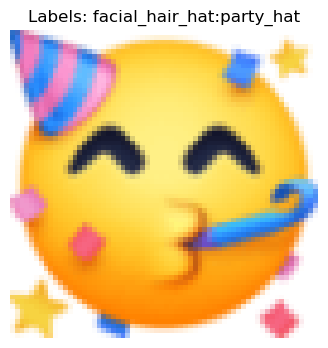

In [16]:
# Load Labels and Mappings
categories, cat_to_idx, idx_to_cat, folder_to_cats = load_labels_and_mappings()

print(f"Found {len(categories)} flattened categories:")
for i, cat in idx_to_cat.items():
    print(f"  {i}: {cat}")

# Initialize Data
data = load_conditional_dataset(folder_to_cats=folder_to_cats, num_categories=len(categories))
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=2)

# Show a sample
img, label_vec = next(iter(dataloader))
plt.figure(figsize=(4,4))
show_tensor_image(img[0])
active = (label_vec[0] > 0).nonzero(as_tuple=True)[0].tolist()
active_names = ", ".join(idx_to_cat[i] for i in active)
plt.title(f"Labels: {active_names}")
plt.show()

## Step 1: The forward process = Noise scheduler

We use the standard linear beta schedule for DDPM.

In [17]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 500
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

## Step 2: The Model (Conditional U-Net)

We use the `ConditionalUnet` which accepts `class_labels` in addition to `timestep`.

In [18]:
model = ConditionalUnet(num_classes=len(categories))
print("Num params: ", sum(p.numel() for p in model.parameters()))
model.to(device)

Num params:  10059331


ConditionalUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): SiLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
  )
  (class_emb): Embedding(55, 128)
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): ResnetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (adagn1): AdaGroupNorm(
        (group_norm): GroupNorm(8, 64, eps=1e-05, affine=True)
        (time_proj): Linear(in_features=128, out_features=128, bias=True)
      )
      (relu): SiLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (adagn2): AdaGroupNorm(
        (group_norm): GroupNorm(8, 64, eps=1e-05, affine=True)
        (time_proj): Linear(in_features=128, out_features=128, bias=True)
      )
      (skip_connection): Identity()
    )
    (1): Conv2d(64, 128, kernel_size=(4, 4)

## Step 3: The Loss

We adapt the loss function to pass `labels` to the model.

In [ ]:
def get_loss(model, x_0, t, labels_vec, device=device, cond_dropout=0.1):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)

    # Classifier-Free Guidance dropout on labels
    if cond_dropout and cond_dropout > 0:
        drop_mask = (torch.rand(labels_vec.shape[0], device=device) < cond_dropout).float().view(-1, 1)
        labels_in = labels_vec.to(device) * (1.0 - drop_mask)
    else:
        labels_in = labels_vec.to(device)

    # Pass multi-hot labels to model
    noise_pred = model(x_noisy, t, labels_in)
    # return F.mse_loss(noise, noise_pred)
    return F.l1_loss(noise, noise_pred)

## Sampling

We adapt the sampling function to accept `class_label_idx`.

In [20]:
@torch.no_grad()
def build_label_vec_for_id(target_id, num_categories, folder_to_cats):
    fid = str(target_id)
    vec = torch.zeros((1, num_categories), dtype=torch.float32, device=device)
    indices = folder_to_cats.get(fid, [])
    for ci in indices:
        if 0 <= ci < num_categories:
            vec[0, ci] = 1.0
    return vec

@torch.no_grad()
def sample_timestep_cfg(x, t, label_vec, guidance_scale=3.0):
    """
    DDPM one-step with classifier-free guidance using unconditional and conditional predictions.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # Unconditional and conditional noise predictions
    pred_noise_uncond = model(x, t, torch.zeros_like(label_vec))
    pred_noise_cond = model(x, t, label_vec)
    pred_noise = pred_noise_uncond + guidance_scale * (pred_noise_cond - pred_noise_uncond)

    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * pred_noise / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t.item() == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_plot_conditional_by_id(target_id=None, steps=None, guidance_scale=3.0, save_path=None):
    if steps is None:
        steps = T
    if target_id is None:
        if len(folder_to_cats) == 0:
            raise ValueError("folder_to_cats is empty; ensure labels.json parsed correctly.")
        target_id = random.choice(list(folder_to_cats.keys()))
    fid = str(target_id)
    print(f"Generating sample for id: {fid}")

    label_vec = build_label_vec_for_id(fid, len(categories), folder_to_cats)
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)

    traj = [img.clone()]
    num_plots = 10
    stepsize = max(steps // num_plots, 1)

    for i in range(steps-1, -1, -1):
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep_cfg(img, t, label_vec, guidance_scale=guidance_scale)
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            traj.append(img.clone())
    if traj[-1] is not img:
        traj.append(img.clone())

    plt.figure(figsize=(15, 3))
    plt.axis('off')
    for i in range(len(traj)):
        plt.subplot(1, len(traj), i + 1)
        show_tensor_image(traj[i].detach().cpu())
    plt.subplots_adjust(wspace=0.0, hspace=0)
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

## Training Loop

In [21]:
from torch.optim import AdamW
import time
import csv
import pandas as pd

optimizer = AdamW(model.parameters(), lr=2e-4)
epochs = 1000

checkpoint_dir = "ddpm_conditional_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
log_file = os.path.join(checkpoint_dir, "train_log.csv")
best_model_path = os.path.join(checkpoint_dir, "best_model.pt")

start_epoch = 0
best_loss = float("inf")

# Resume logic
if os.path.exists(log_file) and os.path.getsize(log_file) > 0:
    try:
        log_df = pd.read_csv(log_file)
        if not log_df.empty:
            last_epoch = log_df['epoch'].iloc[-1]
            start_epoch = int(last_epoch) + 1
            print(f"Resuming from epoch {start_epoch}")
    except:
        pass

if os.path.exists(best_model_path):
    print(f"Loading best model from {best_model_path}")
    checkpoint = torch.load(best_model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    best_loss = checkpoint.get('loss', float('inf'))

if not os.path.exists(log_file):
    with open(log_file, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["epoch", "avg_loss", "duration_sec"])

pending_rows = []
flush_every = 10

for epoch in range(start_epoch, epochs):
    model.train()
    epoch_loss = 0.0
    start_time = time.perf_counter()
    
    for step, (images, labels_vec) in enumerate(dataloader):
        optimizer.zero_grad()
        
        x_0 = images.to(device)
        labels_vec = labels_vec.to(device)
        
        current_batch_size = x_0.shape[0]
        t = torch.randint(0, T, (current_batch_size,), device=device).long()
        
        loss = get_loss(model, x_0, t, labels_vec, device=device, cond_dropout=0.1)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(dataloader)
    duration = time.perf_counter() - start_time
    
    pending_rows.append([epoch, avg_epoch_loss, duration])

    if avg_epoch_loss < best_loss:
        best_loss = avg_epoch_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_loss,
        }, best_model_path)
        print(f"New best model saved! Epoch: {epoch} Loss: {best_loss:.4f}")
        
        model.eval()
        save_path = os.path.join(checkpoint_dir, f"epoch{epoch}_loss{best_loss:.4f}.png")
        sample_plot_conditional_by_id(steps=T, guidance_scale=3.0, save_path=save_path)

    if (len(pending_rows) >= flush_every) or (epoch == epochs - 1):
        with open(log_file, "a", newline="") as f:
            writer = csv.writer(f)
            writer.writerows(pending_rows)
        pending_rows.clear()

Resuming from epoch 1200
Loading best model from ddpm_conditional_checkpoints/best_model.pt


Generating sample for id: 53


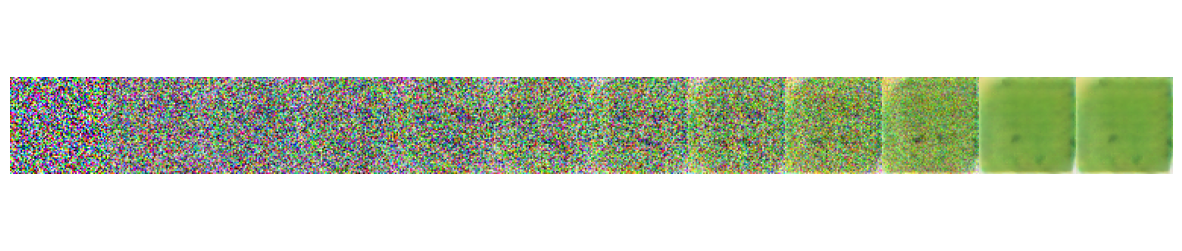

Generating sample for id: 54


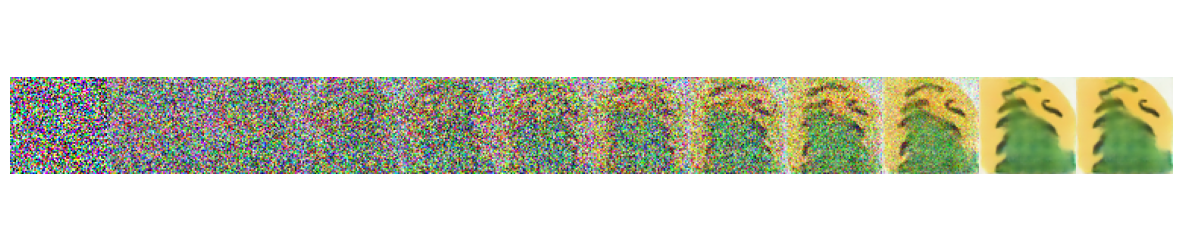

Generating sample for id: 56


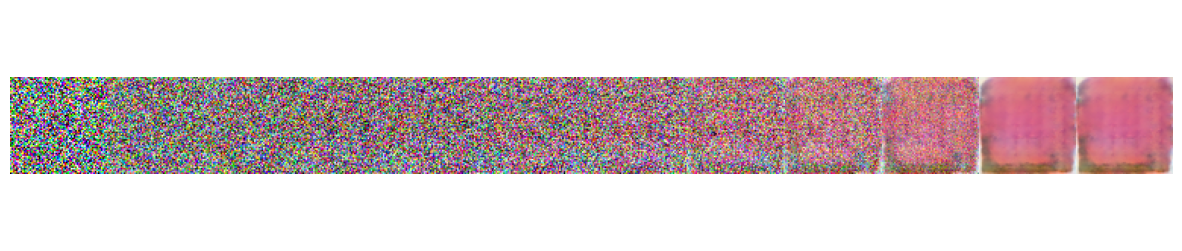

Generating sample for id: 93


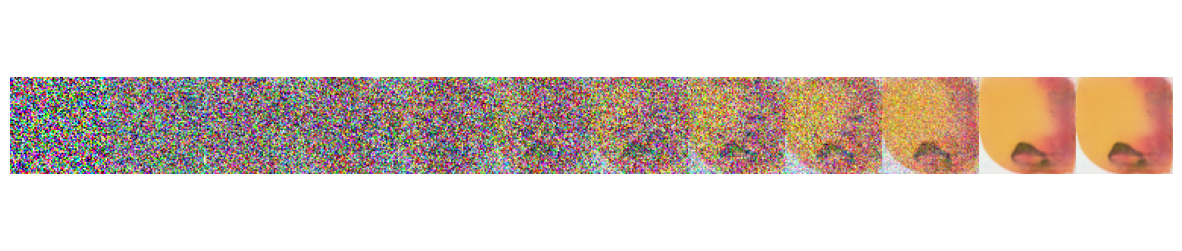

Generating sample for id: 57


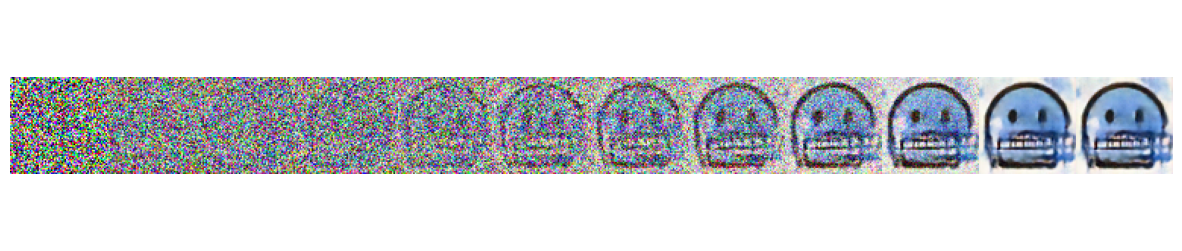

In [22]:
# Generate samples for a few ids
model.eval()
example_ids = list(folder_to_cats.keys())[:5]
for fid in example_ids:
    sample_plot_conditional_by_id(fid, steps=T, guidance_scale=3.0)